In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from autodiff.engine import Scalar
from autodiff.nn import MLP

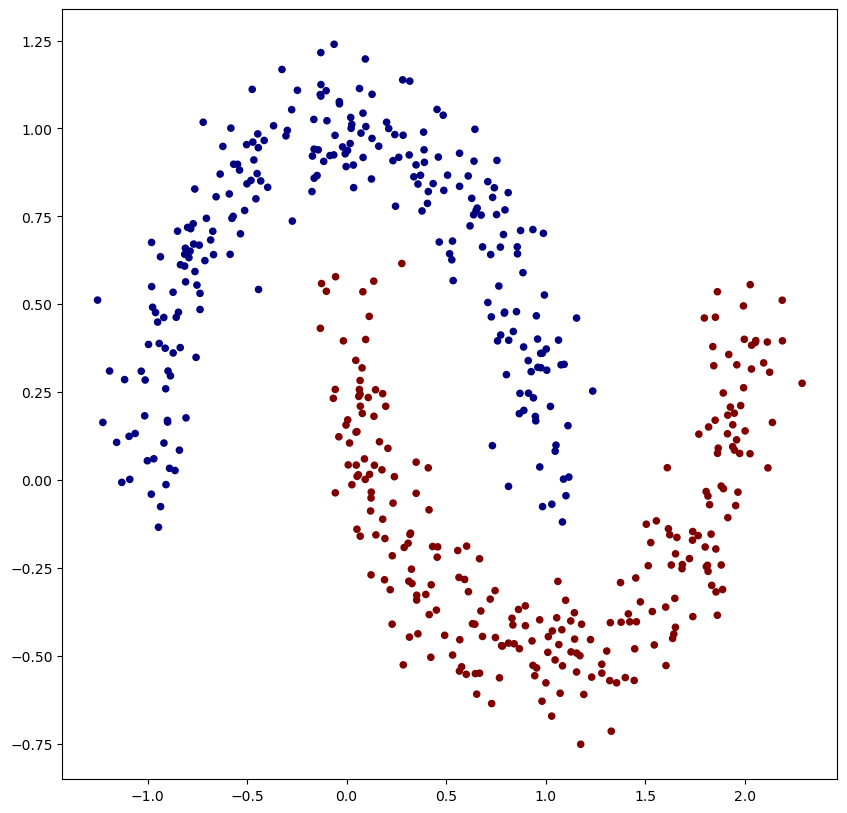

In [3]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=500, noise=0.1)

# make output +-1 for hinge loss
y = y * 2 - 1

plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
model = MLP(2, [15, 15, 1], ['gelu', 'gelu', 'linear'])

In [5]:
def hinge_loss(batch_size):
    batch_indices = np.random.permutation(X.shape[0])[:batch_size]
    X_batch, y_batch = X[batch_indices], y[batch_indices]

    # batch data points
    inputs = [list(map(Scalar, point)) for point in X_batch]
    
    # forward pass
    outputs = list(map(model, inputs))

    # hinge loss
    losses = [(1 - y_i * output_i).relu() for y_i, output_i in zip(y_batch, outputs)]
    total_loss = sum(losses) * (1.0 / len(losses))

    # L2 (Ridge) regularization
    alpha = 1e-4
    reg_penalty = alpha * sum((p * p for p in model.parameters()))
    batch_loss = total_loss + reg_penalty

    # accuracy for debugging
    accuracy = [(y_i > 0) == (output_i.value > 0) for y_i, output_i in zip(y_batch, outputs)]

    return batch_loss, sum(accuracy) / len(accuracy)

In [6]:
# minibatch stochastic gradient descent
for i in range(100):
    # forward propagation
    loss, accuracy = hinge_loss(100)

    # backward propagation
    model.zero_grad()
    loss.backward()

    learning_rate = 1.0 - 0.8 * i / 100
    for p in model.parameters():
        p.value -= learning_rate * p.grad

    print(f"step {i}, loss {loss.value}, accuracy {accuracy * 100}%")

step 0, loss 1.152290333307479, accuracy 37.0%
step 1, loss 0.44881253950273126, accuracy 84.0%
step 2, loss 0.34596046265807834, accuracy 87.0%
step 3, loss 0.5093644301098879, accuracy 84.0%
step 4, loss 0.31107672848764945, accuracy 85.0%
step 5, loss 0.6885024285372545, accuracy 77.0%
step 6, loss 0.7219993818975705, accuracy 75.0%
step 7, loss 0.3038957042537616, accuracy 85.0%
step 8, loss 0.4151546689706354, accuracy 81.0%
step 9, loss 0.34644923352692913, accuracy 86.0%
step 10, loss 0.30947303551475785, accuracy 87.0%
step 11, loss 0.30218618204961933, accuracy 85.0%
step 12, loss 0.27679708763119354, accuracy 88.0%
step 13, loss 0.22743445251491473, accuracy 92.0%
step 14, loss 0.24450680227100904, accuracy 90.0%
step 15, loss 0.3249154707679374, accuracy 85.0%
step 16, loss 0.22910008661497794, accuracy 89.0%
step 17, loss 0.2584270472585946, accuracy 90.0%
step 18, loss 0.17322422694744724, accuracy 94.0%
step 19, loss 0.17378897706415938, accuracy 95.0%
step 20, loss 0.228

(-1.751632027448438, 1.998367972551562)

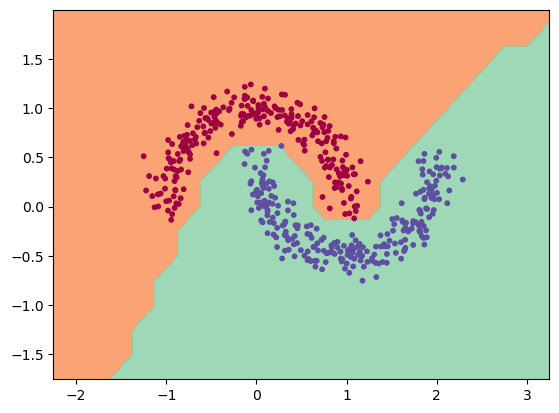

In [7]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Scalar, point)) for point in Xmesh]
outputs = list(map(model, inputs))
Z = np.array([output.value > 0 for output in outputs])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())